In [5]:
import os
import json
import glob

from matplotlib import pyplot as plt
from matplotlib import markers

from collections import OrderedDict

from configs import load

import numpy as np

In [11]:
results=[]
temp=[]
for file in glob.glob("../subjects/ismrm_basic/predicted_fibers/2019-11-22-*"):    
    config_path = os.path.join(file, "config.yml")
    temp.append(load(config_path)["model_path"].split("T=")[1][:6])
    
models = glob.glob("../models/Entrack/conditional/2019-11-13/22:24:08/model_T=*.h5")
T = [m.split("_T=")[1].split(".h")[0] for m in models]

set(T) - set(temp)

set()

In [39]:
def plot_score(results, temp, score_name):
    
    scores = [r[score_name] for r in results]
    
    plt.plot(temp, scores, "-o")
    plt.ylabel(score_name)
    plt.xlabel("T")
    plt.xticks(rotation=90)

In [40]:
def plot_OR_OL(results, temp):
    
    OL = [r["mean_OL"] for r in results]
    OR = [r["mean_OR"] for r in results]
    
    color = [plt.get_cmap("brg")(0.5*i/len(temp)) for i in range(len(temp))]

    plt.scatter(OL, OR, c=color)
    plt.xlabel("OL")
    plt.ylabel("OR")
    

In [1]:
# 2019-11-22-16:24:07 to 2019-11-22-19:32:18, pred_fn = sample
# 2019-11-22-21:04:43 to 2019-11-22-23:14:19, pred_fn = mean
# "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*"

def get_results(dir_glob):
    results=[]
    temp=[]
    for directory in glob.glob(dir_glob):

        timestamp = directory.split("/")[-1]
        result_path = os.path.join(directory, "scorings", "scores", timestamp + ".json")

        if os.path.exists(result_path):
            config_path = os.path.join(directory, "config.yml")
            config = load(config_path)
            temp.append(float(config["model_path"].split("T=")[1][:6]))
            with open(result_path) as json_file:
                results.append(json.load(json_file))

    order = np.argsort(temp)
    temp = [temp[i] for i in order]
    results = [results[i] for i in order]
    
    return temp, results

In [3]:
def get_runs(*dir_globs):
    
    T = []
    R = []
    
    for dir_glob in dir_globs:
        t, r = get_results(dir_glob)
        T.append(t)
        R.append(r)
        
    return T, R

In [83]:
def average_runs(*dir_globs, metric):
    
    T, R = get_runs(*dir_globs)
    
    Tsets = []
    for t in T:
        Tsets.append(set(t))
    
    common_T = set()
    for tset in Tsets:
        common_T = common_T.union(tset)
    
    common_T = list(common_T)
    common_T.sort()
    
    metric_means = []
    for t in common_T:
        metric_values = []
        for i, r in enumerate(R):
            if t in T[i]:
                metric_values.append(r[T[i].index(t)][metric])
        metric_means.append(np.mean(metric_values))
    
    return common_T, metric_means

In [94]:
def plot_average(*dir_globs, metric="VC"):
    
    common_T, metric_means = average_runs(*dir_globs, metric=metric)
    
    plt.plot(common_T, metric_means, "-o")
    plt.ylabel(metric)
    plt.xlabel("T")
    plt.xticks(rotation=90)

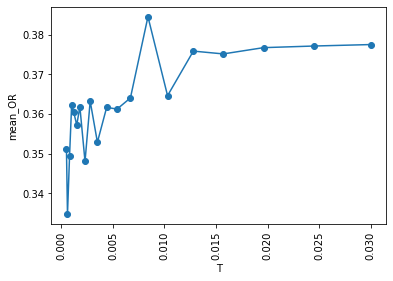

In [95]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_OR"
)

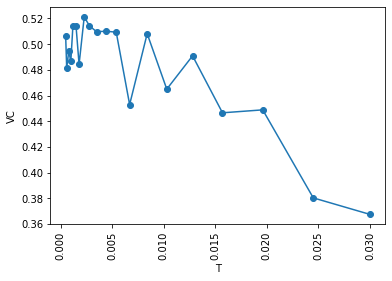

In [96]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VC"
)

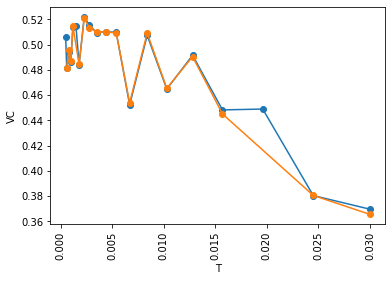

In [101]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    metric="VC"
)
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VC"
)

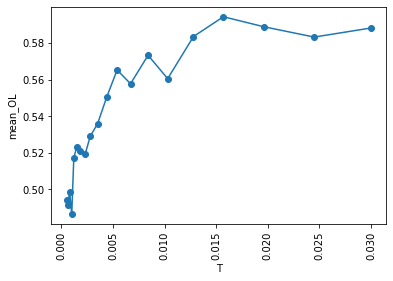

In [97]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_OL"
)

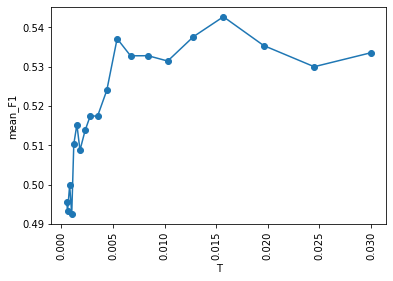

In [98]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="mean_F1"
)

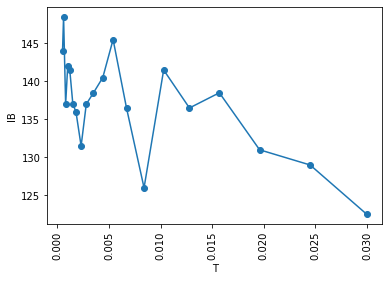

In [99]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="IB"
)

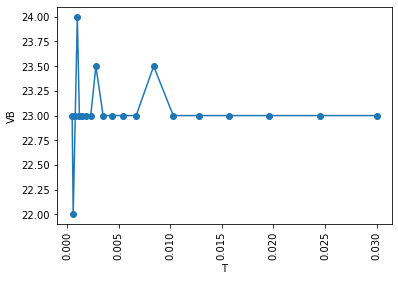

In [93]:
plot_average(
    "../subjects/ismrm_basic/predicted_fibers/2019-11-22-1*",
    "../subjects/ismrm_basic/predicted_fibers/2019-11-23-*",
    metric="VB"
)

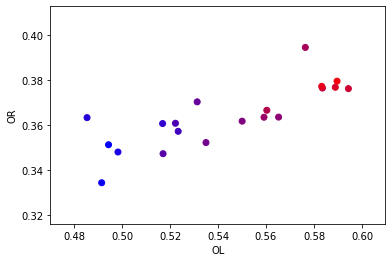

In [84]:
plot_OR_OL(results, temp)